##### Classical SVM Implementation - Spambase

In [24]:
# Library Imports

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# --- Import Spambase Column Names ---
spambase_columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    # finally the target label column:
    "label"
]

# Load data
file_path = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\spambase\spambase.data'
df = pd.read_csv(file_path, header=None, names=spambase_columns)


In [26]:
# 2. Some basic processing
print(f"Original shape of Spambase data: {df.shape}") # Prints original dataset shape
df.drop_duplicates(inplace=True) # Remove duplicates
print(f"Shape after dropping duplicates: {df.shape}\n") # Then print again the new shape

Original shape of Spambase data: (4601, 58)
Shape after dropping duplicates: (4210, 58)



In [27]:
sample_fraction = 0.2                     
X = df.drop('label', axis=1)
y = df['label']

X_sample, _, y_sample, _ = train_test_split(
    X, y,
    test_size=(1 - sample_fraction),
    stratify=y,
    random_state=42
)

print(f"Using stratified subsample of {len(X_sample)} instances "
      f"({sample_fraction*100:.0f}% of original)\n")

# Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.30,
    random_state=42,
    stratify=y_sample
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing  set shape: {X_test.shape}\n")


Using stratified subsample of 842 instances (20% of original)

Training set shape: (589, 57)
Testing  set shape: (253, 57)



In [28]:
# Scaling and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # use .transform not fit_transform

# Convert back to DataFrames to retain column names for the next step
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [29]:
# --- Feature Selection ---
print("--- Feature Selection ---")
THRESH = 0.9
# Calculate correlation matrix on the SCALED TRAINING data
corr_matrix_train = X_train_scaled_df.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold
columns_to_drop = set()
for column in upper_triangle.columns:
    high_corr_partners = upper_triangle.index[upper_triangle[column] > THRESH].tolist()
    if high_corr_partners:
        for partner in high_corr_partners:
            # IMPORTANT: Check correlation with the TRAINING target variable
            corr_main_vs_target = y_train.corr(X_train_scaled_df[column])
            corr_partner_vs_target = y_train.corr(X_train_scaled_df[partner])
            
            print(f"Found pair: ('{column}', '{partner}') with correlation > {THRESH}")
            if abs(corr_main_vs_target) < abs(corr_partner_vs_target):
                columns_to_drop.add(column)
                print(f"-> Dropping '{column}' (weaker correlation with target)")
            else:
                columns_to_drop.add(partner)
                print(f"-> Dropping '{partner}' (weaker correlation with target)")

to_drop_final = sorted(list(columns_to_drop))
print(f"\nTotal features to drop ({len(to_drop_final)}): {to_drop_final}")

# Drop the identified columns from both training and test sets
X_train_selected = X_train_scaled_df.drop(columns=to_drop_final)
X_test_selected = X_test_scaled_df.drop(columns=to_drop_final)

print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}\n")

--- Feature Selection ---
Found pair: ('word_freq_415', 'word_freq_857') with correlation > 0.9
-> Dropping 'word_freq_857' (weaker correlation with target)

Total features to drop (1): ['word_freq_857']

Original number of features: 57
Number of features after selection: 56



c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\User\anaconda3\envs\qsvm_conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [30]:
# PCA
n_components = 4
pca = PCA(n_components=n_components, random_state=42)

# Fit on the selected training data and transform both sets
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print(f"Shape after PCA (Train): {X_train_pca.shape}")
print(f"Shape after PCA (Test):  {X_test_pca.shape}")

Shape after PCA (Train): (589, 4)
Shape after PCA (Test):  (253, 4)


##### Linear SVM Implementation

In [31]:
# First SVM Model - Classical Baseline (Linear SVM)
print("--- Training Classical Linear SVM ---")
start_time_linear = time.time()

param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight':['balanced']
}

grid_linear = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid_linear, cv=5, n_jobs=-1, verbose=0)
grid_linear.fit(X_train_pca, y_train)

best_linear_svm = grid_linear.best_estimator_
training_time_linear = time.time() - start_time_linear

print(f"Best parameters found: {grid_linear.best_params_}")
print(f"Training time: {training_time_linear:.2f} seconds\n")

--- Training Classical Linear SVM ---
Best parameters found: {'C': 0.1, 'class_weight': 'balanced'}
Training time: 5.12 seconds



In [32]:
y_train_pred_linear = best_linear_svm.predict(X_train_pca)
y_test_pred_linear = best_linear_svm.predict(X_test_pca)

train_accuracy_linear = accuracy_score(y_train, y_train_pred_linear)
test_accuracy_linear = accuracy_score(y_test, y_test_pred_linear)
gen_gap_linear = abs(train_accuracy_linear - test_accuracy_linear)

print("--- Linear SVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy_linear:.4f}")
print(f"Test Accuracy:     {test_accuracy_linear:.4f}")
print(f"Generalization Gap: {gen_gap_linear:.4f}\n")

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_linear))

--- Linear SVM Evaluation (Spambase) ---
Training Accuracy: 0.8862
Test Accuracy:     0.8854
Generalization Gap: 0.0009

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       152
           1       0.86      0.85      0.86       101

    accuracy                           0.89       253
   macro avg       0.88      0.88      0.88       253
weighted avg       0.89      0.89      0.89       253



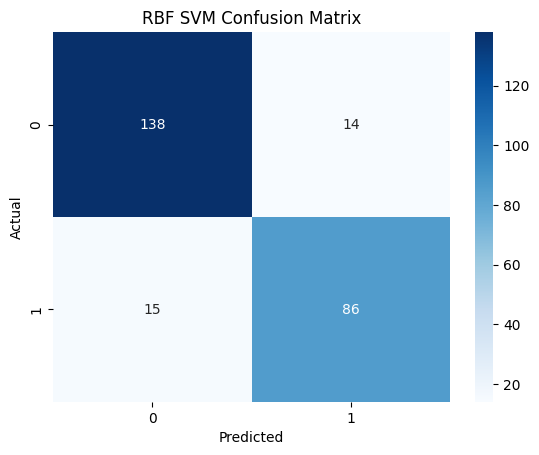

In [33]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred_linear)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RBF SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### RBF Kernel SVM Model Implementation

In [34]:
print("\n--- Training Classical RBF SVM ---")
start_time_rbf = time.time()

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'class_weight':['balanced']
}
grid_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid_rbf, cv=5, n_jobs=-1, verbose=0)
grid_rbf.fit(X_train_pca, y_train)

best_rbf_svm = grid_rbf.best_estimator_
training_time_rbf = time.time() - start_time_rbf

print(f"Best parameters found: {grid_rbf.best_params_}")
print(f"Training time: {training_time_rbf:.2f} seconds\n")


--- Training Classical RBF SVM ---
Best parameters found: {'C': 100, 'class_weight': 'balanced', 'gamma': 0.01}
Training time: 0.17 seconds



In [35]:
# Evaluation for RBF SVM
y_train_pred_rbf = best_rbf_svm.predict(X_train_pca)
y_test_pred_rbf = best_rbf_svm.predict(X_test_pca)

train_accuracy_rbf = accuracy_score(y_train, y_train_pred_rbf)
test_accuracy_rbf = accuracy_score(y_test, y_test_pred_rbf)
gen_gap_rbf = abs(train_accuracy_rbf - test_accuracy_rbf)

print("--- RBF SVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy_rbf:.4f}")
print(f"Test Accuracy:     {test_accuracy_rbf:.4f}")
print(f"Generalization Gap: {gen_gap_rbf:.4f}\n")

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rbf))

--- RBF SVM Evaluation (Spambase) ---
Training Accuracy: 0.9015
Test Accuracy:     0.8854
Generalization Gap: 0.0162

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       152
           1       0.88      0.83      0.85       101

    accuracy                           0.89       253
   macro avg       0.88      0.88      0.88       253
weighted avg       0.89      0.89      0.88       253



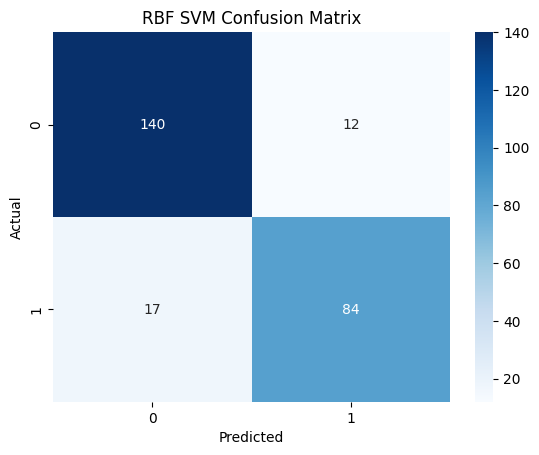

In [36]:
cm = confusion_matrix(y_test, y_test_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RBF SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()